[View in Colaboratory](https://colab.research.google.com/github/Lemonn17/notebooks/blob/master/HW1Embeded%20system.ipynb)

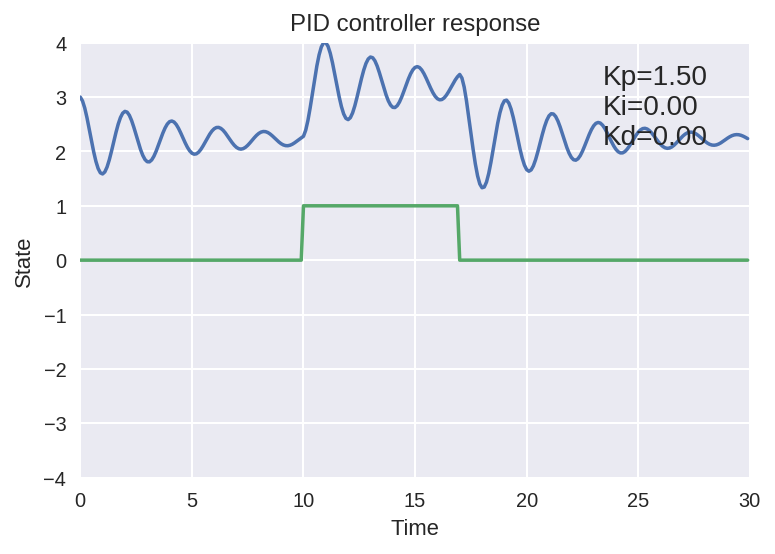

In [30]:
# imports we need to graph stuff
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import animation, rc
import numpy as np
import random
from IPython.display import HTML


# This function takes the current error, 3 PID constants,
# and an array of previous responses and returns the PID response
def pid_response(errors, Kp, Ki, Kd, time_delta):
    current_error = errors[-1]
    if len(errors) > 1:
        prev_error = errors[-2]
    else:
        # if we don't have two error measurements, just reuse
        # the first error
        prev_error = current_error

    proportional = Kp*current_error
    integral = Ki* sum(errors) * time_delta
    derivative = Kd*(current_error - prev_error) / time_delta
    
    return proportional + integral + derivative

# please ignore
def bang_response(errors, Kp, Ki, Kd, time_delta):
    return np.sign(errors[-1]) * 0.5
  
p_response = 0
constant_shift = 0.2

def process(res, state):
    global p_response
    p_response = p_response*0.96 - 0.06*res + constant_shift
    # add "real-world" contraints
    p_response = min(0.3, p_response)
    p_response = max(-0.3, p_response)
    return state + p_response
  
def error(s, d):
    return s - d
  
def simulate_pid(Kp, Ki, Kd):
    time_delta = 0.1
    duration = 30
    times = np.arange(0, duration, time_delta)

    desired = np.zeros(times.size)
    desired[100:170] = 1

    states = np.zeros(times.size)
    states[0] = 3 # initial state

    errors = np.zeros(times.size)
    errors[0] = error(states[0], desired[0]) # initial error

    for i in range(1, len(times)):
        res = pid_response(errors[:i], Kp, Ki, Kd, time_delta=time_delta)
        state = process(res, states[i - 1])
        states[i] = state
        errors[i] = error(state, desired[i])
    
    return times, states, desired, errors
fig, ax = plt.subplots()
ax.set_title("PID controller response")
ax.set_xlabel("Time")
ax.set_ylabel("State")
line, = ax.plot([], [])
ax.set_xlim(( 0, 30))
ax.set_ylim((-4, 4))
fmt_str = 'Kp=%.2f\nKi=%.2f\nKd=%.2f'
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

tex = ax.text(0.78, 0.95, '', transform=ax.transAxes, fontsize=14, verticalalignment='top')

desired = np.zeros(30 * 10)
desired[100:170] = 1
ax.plot(np.arange(0, 30, 0.1), desired)

def animate(i):
    Kp = 1.5 - min(i,100)*0.01
    Kd = 0
    Ki = 0
    if i > 100:
        Kd = min((i-100)/2.0, 30) * 0.01
    t, s, d, e = simulate_pid(Kp, Ki, Kd)
    line.set_data(t, s)
    s = fmt_str % (Kp,Ki,Kd)
    tex.set_text(s)

    return (line,)

anim = animation.FuncAnimation(fig, animate,
                               frames=250, interval=20, blit=True)
# display HTML
#HTML(anim.to_html5_video())
# save as GIF
#anim.save('pid_animation.gif', writer='imagemagick')